# GEMS cru-ts-4.06 Tutorial

### Section 1: Establish connection and explore available data

In [1]:
# Imports used in this notebook
from requests import Session

import pandas as pd
import rasterio
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('..')

# Import your API key from a file
from api_key import key
# from keys import write_key

# Establish connection
s = Session()
s.headers.update({'apikey': key})
api_url = 'https://exchange-1.gems.msi.umn.edu/climate/v2/cru-ts-4.06'

# Define bounding box by string of "upper left lon, lat, bottom right lon, lat" in decimal degrees, no spaces
bbox = '-150.1,20.2,-50.3,65.4'

# Sample AOI of the upper midwest
aoi = {"type": "Polygon",
        "coordinates":
            [[[-104.02, 48.92],
            [-104.06, 40.95],
            [-102.03, 41.01],
            [-101.99, 40.04],
            [-87.49, 39.96],
            [-86.88, 45.36],
            [-90.33,46.55],
            [-89.59,47.99],
            [-95.00,49.24],
            [-104.02,48.92]]],
      }

In [2]:
# List available variables

res = s.get(f'{api_url}/layer')
variables = pd.json_normalize(res.json())
display(variables)

,name,units,description,discrete,id
0,Mean 2m temperature,degrees Celsius,Monthly average of 2m temperature (degrees Cel...,False,3
1,Diurnal 2m temperature range,degrees Celsius,Monthly average of daily diurnal 2m temperatur...,False,4
2,Precipitation rate,mm/month,Precipitation rate (mm/month),False,5
3,Vapour pressure,hPa,Vapour pressure (hPa),False,6
4,Wet days,days per month,Number of days per month with >= 0.1 mm of pre...,False,7
5,Cloud cover,percentage,Average monthly cloud cover percentage,False,8
6,Frost days,days per month,Monthly number of days when frost occurs,False,9
7,Minimum 2m temperature,degrees Celsius,Average of daily minimum 2m temperatures in a ...,False,10
8,Maximum 2m temperature,degrees Celsius,Average of daily maximum 2m temperatures in a ...,False,11
9,Potential evapo-transpiration,mm/day,Monthly average potential evapo-transpiration ...,False,12


In [3]:
# Use the name of a variable to programmatically get its ID

precip_id = variables.loc[variables['name'] == 'Precipitation rate', 'id'].iloc[0]

# Get ID for June, 1977 precipitation data
params = {'layer': precip_id,
          'begin': '1977-06',
          'end': '1977-07'}

raster_id = s.get(f'{api_url}/object/search', params=params).json()[0]['id']
print('Raster ID:', raster_id)

Raster ID: 3826


In [4]:
# Get metadata for a raster ID

metadata = s.get(f'{api_url}/object/{raster_id}')
metadata_df = pd.json_normalize(metadata.json())
display(metadata_df)

name = metadata_df['name'].iloc[0]
layer_id = metadata_df['layer_id'].iloc[0]
description = metadata_df['description'].iloc[0]
units = metadata_df['units'].iloc[0]
time_range = metadata_df['t_ranges'].iloc[0][0]
t_start, t_end = time_range['begin'], time_range['end']
print('Variable name:', name, '\n'
      'Variable ID:', layer_id, '\n'
      'Raster ID:', raster_id, '\n'
      'Description:', description, '\n'
      'Units:', units, '\n'
      'Time range:', time_range, '\n'
      'Begin time:', t_start, '\n'
      'End time', t_end
      )

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,3826,0,"[{'begin': '1977-06', 'end': '1977-07'}]",None,None,Precipitation rate,mm/month,Precipitation rate (mm/month),5


Variable name: Precipitation rate 
Variable ID: 5 
Raster ID: 3826 
Description: Precipitation rate (mm/month) 
Units: mm/month 
Time range: {'begin': '1977-06', 'end': '1977-07'} 
Begin time: 1977-06 
End time 1977-07


### Section 2: Explore values for a single raster

In [5]:
# Get the value at a lat, lon point

params = {'lat': 46.1,
          'lon': -93.7}

point_value = s.get(f'{api_url}/object/{raster_id}/point', params=params).json()['value']
print(f'Raster value at {params["lat"]}, {params["lon"]}:', point_value)

Raster value at 46.1, -93.7: 98.5999984741211


In [6]:
# Get summary statistics of values in a geoJSON area of interest
# Any bounding box query can be converted to a geoJSON query
# by changing the request type from 'get' to 'post', and
# adding the 'json' keyword argument set to your geoJSON AOI
#
# Note if the result returned is 'None' is likely that your AOI
# did not intersect the center of a cell. Try the point function.

res = s.post(f'{api_url}/object/{raster_id}/stats', json=aoi)
stats_df = pd.json_normalize(res.json())
display(stats_df)

,count,sum,mean,stddev,min,max
0,952,79221.701424,83.216073,18.606121,34.0,124.5


In [7]:
# Calculate the quantiles of the raster cell values in a bounding box

params = {'bbox': bbox,
          'q': [0, 0.1, 0.3, 0.5, 0.9, 1]} # Omit 'q' parameter for default of [0, 0.25, 0.5, 0.75, 1]
res = s.get(f'{api_url}/object/{raster_id}/quantiles', params=params)
quantiles_df = pd.json_normalize(res.json())
display(quantiles_df)

,quantile,value
0,0.0,0.000000
1,0.1,16.350000
2,0.3,38.700001
3,0.5,59.700001
4,0.9,118.900002
5,1.0,329.000000


,min,max,count,percent
0,0.000000,36.555556,4088,0.280461
1,36.555556,73.111111,4995,0.342687
2,73.111111,109.666667,3551,0.243620
3,109.666667,146.222222,1243,0.085277
4,146.222222,182.777778,458,0.031422
5,182.777778,219.333333,160,0.010977
6,219.333333,255.888889,60,0.004116
7,255.888889,292.444444,20,0.001372
8,292.444444,329.000000,1,0.000069


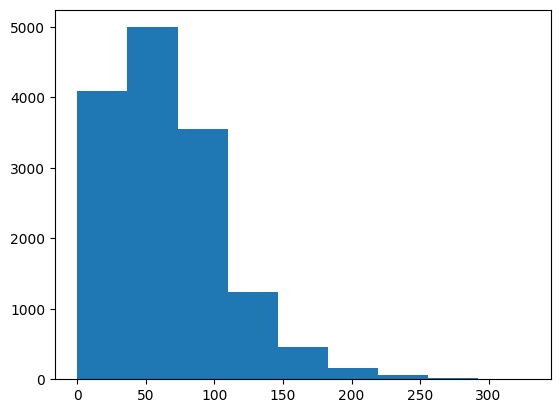

In [8]:
# Make a histogram raster cell values in a bounding box

params = {'bbox': bbox,
          'nbin': 9} # Omit 'nbin' parameter for default of 14
res = s.get(f'{api_url}/object/{raster_id}/histogram', params=params)
df = pd.json_normalize(res.json())
display(df)

# The dataframe returned is already formatted as a histogram, so we plot it as a bar chart
bar_width = df['max'].iloc[0] # Set bar width equal to bin size
plt.bar(df['max']-(bar_width/2), df['count'], width=bar_width)
plt.show()

### Section 3: View and download a subset of an individual raster

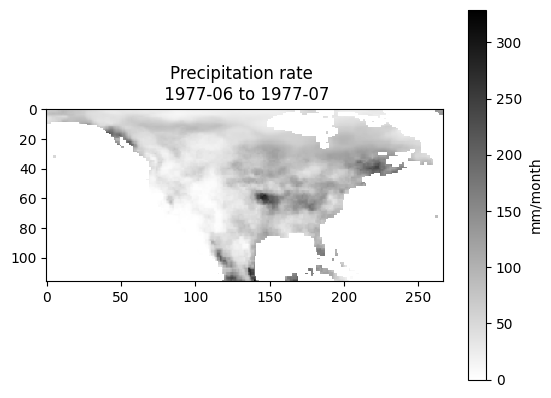

In [9]:
# Visualize the area of a raster within a bounding box

params = {'bbox': bbox}
res = s.get(f'{api_url}/object/{raster_id}/raster', params=params)

# Open the response as a memory file and plot it
with rasterio.MemoryFile(res.content) as memfile:
    with memfile.open() as dataset:
        data = dataset.read(1)
        palette = plt.cm.gray_r.copy()
        plt.imshow(data, cmap=palette)
        plt.title(f'{name} \n {t_start} to {t_end}')
        plt.colorbar(label=units)
    plt.show()

In [10]:
# Download a subset of the raster defined by a bounding box

params= {'bbox': bbox}

res = s.get(f'{api_url}/object/{raster_id}/raster', params=params)
out_path = 'raster_subset.tif' # Change to a local path

with rasterio.MemoryFile(res.content) as memfile:
    with memfile.open() as raster:
        with rasterio.open(out_path, 'w', **raster.profile) as dst:
            dst.write(raster.read(1), 1) # Read the first band (DEM data are single band) of the raster and write to first band of file

### Section 4: Create tabular time series data for an AOI

In [11]:
# Construct a dataframe with columns for average precip, wet days, minimum temperature, and max temperature
# for growing season months (May through September) in years 1975-1982, for the upper midwest.

var_list = ['Precipitation rate',
            'Wet days',
            'Minimum 2m temperature',
            'Maximum 2m temperature'
            ]

res = s.get(f'{api_url}/layer').json()
variables = pd.json_normalize(res)

rows = []

growing_season_months = [5, 6, 7, 8, 9]
start_year = 1975
end_year = 1982


for year in range(start_year, end_year + 1):
    for month in growing_season_months:
        start_date = f'{year}-{str(month).zfill(2)}'
        end_date = f'{year}-{str(month+1).zfill(2)}'
        row = {'time': start_date}
        for var in var_list:
            var_id = variables.loc[variables['name'] == var, 'id'].iloc[0]

            params = {'layer': var_id,
                      'begin': start_date,
                      'end': end_date}

            raster_id = s.get(f'{api_url}/object/search', params=params).json()[0]['id']
            var_value = s.post(f'{api_url}/object/{raster_id}/stats', json=aoi).json()['mean']
            row[var] = var_value

        rows.append(row)

df = pd.DataFrame.from_dict(rows)
display(df)

,time,Precipitation rate,Wet days,Minimum 2m temperature,Maximum 2m temperature
0,1975-05,66.336241,10.348077,7.706933,21.695063
1,1975-06,130.488342,12.776691,12.389286,25.161555
2,1975-07,45.887396,7.494138,15.904937,30.408404
3,1975-08,80.838552,9.456124,14.148425,28.106828
4,1975-09,42.709665,7.174317,6.849370,20.990862
5,1976-05,49.274161,8.248225,5.406303,21.035925
6,1976-06,80.683300,10.816166,12.389916,27.462605
7,1976-07,53.992018,7.688970,14.968803,30.437816
8,1976-08,38.258719,6.774433,13.735399,29.600211
9,1976-09,30.898425,6.359443,7.536765,24.391282


In [12]:
# Alternatively, use the search function to pull all data for two variables between two dates.
# Then construct a dataframe.

var_list = ['Precipitation rate',
            'Maximum 2m temperature']

res = s.get(f'{api_url}/layer').json()
variables = pd.json_normalize(res)

start_date = '1975-01'
end_date = '1982-12'

columns = []
for var in var_list:
    var_id = variables.loc[variables['name'] == var, 'id'].iloc[0]

    params = {'layer': var_id,
              'begin': start_date,
              'end': end_date}

    rasters = s.get(f'{api_url}/object/search', params=params).json()

    raster_attributes = []
    for raster in rasters:
        raster_attributes.append({'time': raster['t_ranges'][0]['begin'], 'id': raster['id']})

    column = []
    for raster in raster_attributes:
        var_value = s.post(f'{api_url}/object/{raster["id"]}/stats', json=aoi).json()['mean']
        row = {'time': raster['time'], var: var_value}
        column.append(row)
    column = pd.DataFrame.from_dict(column).set_index('time')
    columns.append(column)

df = pd.concat(columns, axis=1, join='inner')
display(df)

,Precipitation rate,Maximum 2m temperature
time,,
1975-01,37.009454,-2.308719
1975-02,19.693278,-3.123319
1975-03,46.530568,1.837395
1975-04,79.042333,9.463761
1975-05,66.336241,21.695063
...,...,...
1982-07,110.011346,29.076366
1982-08,76.138762,27.175841
1982-09,60.406829,21.803677
